##Install Dependencies

In [ ]:
from google.colab import drive
import os
import cv2
import numpy as np

#data augmentation
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#to display images and graphs
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import layers, models

In [ ]:
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
#obtaining the labels
data_directory = '/content/drive/MyDrive/Leaf disease Dataset/Wheat'
os.listdir(os.path.join(data_directory))

['Wheat___infected', 'Wheat___Healthy']

In [ ]:
data = ImageDataGenerator(
    rotation_range=20,  # Randomly rotate images by 20 degrees
    zoom_range=0.2,     # Randomly zoom images by 20%
    horizontal_flip=True,  # Randomly flip images horizontally
    brightness_range=(0.8, 1.2),  # Randomly adjust brightness
    rescale=1./255      # Rescale pixel values to [0, 1]
)

In [ ]:
# Apply data augmentation to the images in the directory and load the augmented data
augmented_data = data.flow_from_directory(data_directory, target_size=(256, 256), batch_size=32, class_mode='binary')

Found 2510 images belonging to 2 classes.


In [ ]:
# Convert the augmented data to TensorFlow dataset using image_dataset_from_directory
data = tf.keras.utils.image_dataset_from_directory(data_directory, batch_size=32, image_size=(256, 256), label_mode='binary')

Found 2500 files belonging to 2 classes.


In [ ]:
data_iterator = data.as_numpy_iterator()

In [ ]:
batch = data_iterator.next()

/usr/local/lib/python3.10/dist-packages/matplotlib/text.py:1279: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


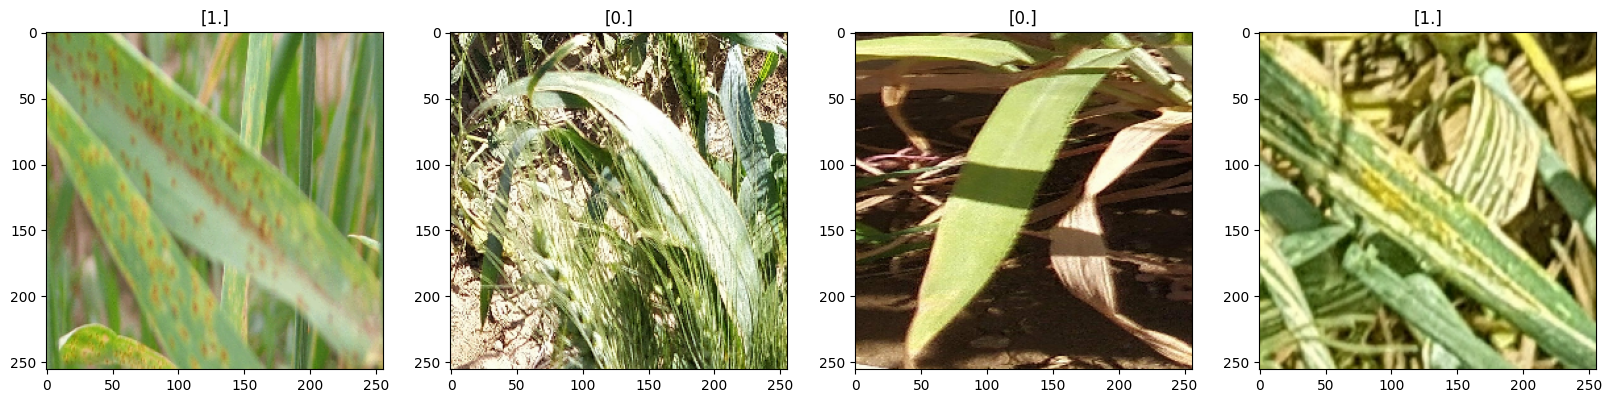

In [ ]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

Data Splitting

In [ ]:
len(data)

79

In [ ]:
train_size = int(len(data)*0.7)
val_size = int(len(data)*0.2)+1
test_size = int(len(data)*0.1)+1

In [ ]:
train_size+test_size+val_size

79

In [ ]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

In [ ]:
print(len(test))
print(len(train))
print(len(val))

8
55
16


Model Building

In [ ]:
# Load EfficientNet-B0 model with pre-trained weights
base_model = tf.keras.applications.EfficientNetB0(
  weights="imagenet", include_top=False, input_shape=(256, 256, 3)
)

16705208/16705208 [==============================] - 1s 0us/step


In [ ]:
# Freeze pre-trained layers to avoid overfitting
for layer in base_model.layers[:]:
  layer.trainable = False

In [ ]:
# Add custom classification head
x = base_model.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(128, activation="relu")(x)
output = layers.Dense(1, activation="sigmoid")(x)

In [ ]:
# Define the entire model
model = models.Model(inputs=base_model.input, outputs=output)

In [ ]:
# Compile the model
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

In [ ]:
# Train the model
hist = model.fit(
    train,
    epochs=10,
    validation_data=val,
)

Epoch 1/10
55/55 [==============================] - 452s 8s/step - loss: 0.1162 - accuracy: 0.9568 - val_loss: 0.0146 - val_accuracy: 0.9980
Epoch 2/10
55/55 [==============================] - 19s 333ms/step - loss: 0.0116 - accuracy: 0.9977 - val_loss: 0.0082 - val_accuracy: 0.9980
Epoch 3/10
55/55 [==============================] - 19s 341ms/step - loss: 0.0074 - accuracy: 0.9994 - val_loss: 0.0046 - val_accuracy: 1.0000
Epoch 4/10
55/55 [==============================] - 21s 370ms/step - loss: 0.0028 - accuracy: 1.0000 - val_loss: 0.0032 - val_accuracy: 1.0000
Epoch 5/10
55/55 [==============================] - 20s 352ms/step - loss: 0.0037 - accuracy: 0.9989 - val_loss: 0.0023 - val_accuracy: 1.0000
Epoch 6/10
55/55 [==============================] - 20s 338ms/step - loss: 0.0017 - accuracy: 1.0000 - val_loss: 0.0021 - val_accuracy: 1.0000
Epoch 7/10
55/55 [==============================] - 19s 334ms/step - loss: 9.9644e-04 - accuracy: 1.0000 - val_loss: 0.0017 - val_accuracy: 1.00

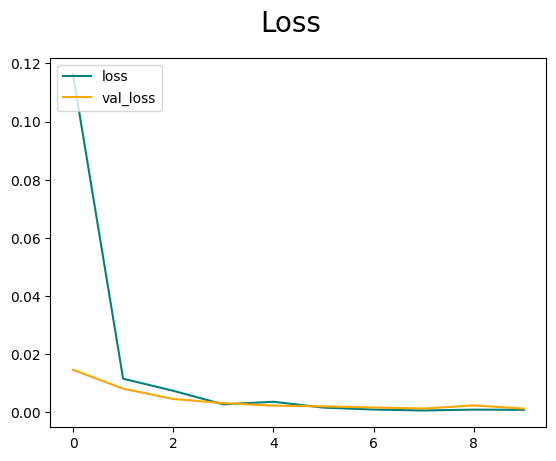

In [ ]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

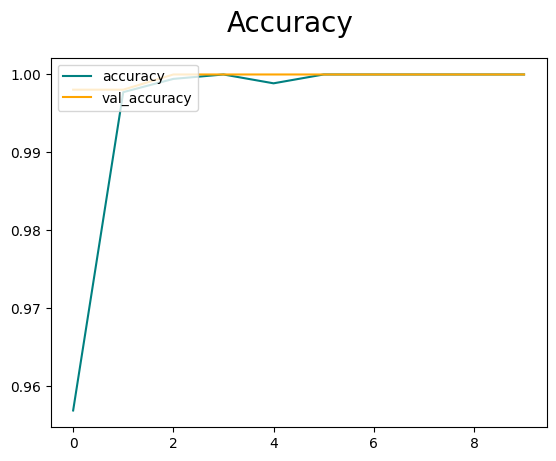

In [ ]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

In [ ]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [ ]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [ ]:
for batch in test.as_numpy_iterator():
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

1/1 [==============================] - 2s 2s/step


In [ ]:
print(pre.result(), re.result(), acc.result())

tf.Tensor(1.0, shape=(), dtype=float32) tf.Tensor(1.0, shape=(), dtype=float32) tf.Tensor(1.0, shape=(), dtype=float32)


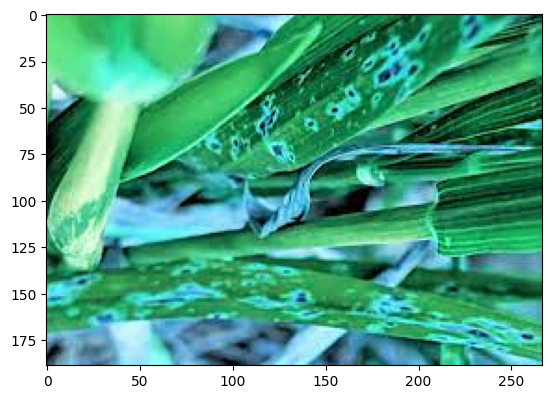

In [ ]:
img = cv2.imread("/content/wheat leaf disease test.jpg")
plt.imshow(img)
plt.show()

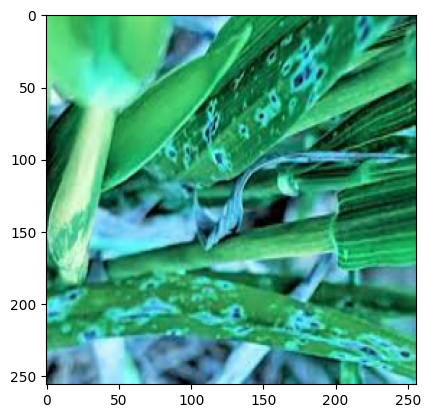

In [ ]:
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [ ]:
yhat = model.predict(np.expand_dims(resize/255, 0))
yhat

1/1 [==============================] - 1s 1s/step


array([[0.8965641]], dtype=float32)

In [ ]:
if yhat > 0.5:
    print(f'Predicted class is infected')
else:
    print(f'Predicted class is healthy')

Predicted class is infected


In [ ]:
yhat = model.predict(np.expand_dims(resize/255, 0))
yhat

1/1 [==============================] - 0s 40ms/step


array([[0.8972065]], dtype=float32)

In [ ]:
model.save(os.path.join('Wheat_Detection.h5'))

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
